In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import sqlite3
import csv

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests


from joblib import Parallel,delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# get the table name from database
conn = sqlite3.connect("BTCH3_BTCUSDT.db")
cursor = conn.cursor()
sql = """select name from sqlite_master where type='table' order by name"""
cursor.execute(sql)
result = cursor.fetchall()
print(result)
print(type(result))
conn.close()

[('ticker_data',)]
<class 'list'>


In [3]:
# get the columns name from table
conn = sqlite3.connect("BTCH3_BTCUSDT.db")
cursor = conn.cursor()
sql = """pragma table_info(ticker_data)"""
cursor.execute(sql)
result = cursor.fetchall()
# print(result)
# print(type(result))
conn.close()

# take into lst
col_name = [i[1] for i in result]

# load data
conn = sqlite3.connect("BTCH3_BTCUSDT.db")
cursor = conn.cursor()
cursor.execute("""select * from  ticker_data""")
result = cursor.fetchall()
# print(result[:1])

# get dataframe 
btc_tickdata_df = pd.DataFrame(result, columns = col_name)

In [4]:
# use mean price
btc_tickdata_df['BTCH3_mid'] = (btc_tickdata_df['BTCH3_bid']+btc_tickdata_df['BTCH3_ask'])/2
btc_tickdata_df['BTCUSDT_mid'] = (btc_tickdata_df['BTCUSDT_bid']+btc_tickdata_df['BTCUSDT_ask'])/2
btc_tickdata = btc_tickdata_df[['Time', 'BTCUSDT_mid', 'BTCH3_mid']]
btc_tickdata.set_index('Time', inplace=True)

# return or diff data
btc_pct_chg = btc_tickdata.pct_change().dropna(axis=0, how='all')
btc_diff = btc_tickdata.diff().dropna(axis=0, how='all')
btc_pctchg_ma5 = btc_pct_chg.rolling(window=5).mean().dropna(axis=0, how='all')
btc_pctchg_ma10 = btc_pct_chg.rolling(window=10).mean().dropna(axis=0, how='all')
btc_pctchg_ma20 = btc_pct_chg.rolling(window=20).mean().dropna(axis=0, how='all')
btc_pctchg_std5 = btc_pct_chg.rolling(window=5).std().dropna(axis=0, how='all')
btc_pctchg_std10 = btc_pct_chg.rolling(window=10).std().dropna(axis=0, how='all')
btc_pctchg_std20 = btc_pct_chg.rolling(window=20).std().dropna(axis=0, how='all')

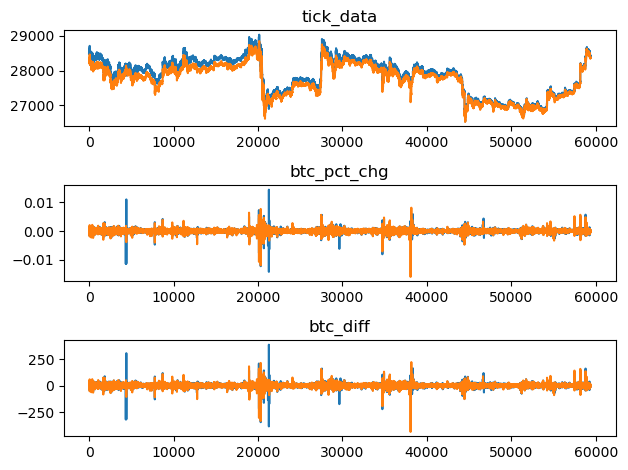

In [5]:
plt.subplot(311)
plt.plot(btc_tickdata['BTCH3_mid'].values)
plt.plot(btc_tickdata['BTCUSDT_mid'].values)
plt.title('tick_data')

plt.subplot(312)
plt.plot(btc_pct_chg['BTCH3_mid'].values)
plt.plot(btc_pct_chg['BTCUSDT_mid'].values)
plt.title('btc_pct_chg')

plt.subplot(313)
plt.plot(btc_diff['BTCH3_mid'].values)
plt.plot(btc_diff['BTCUSDT_mid'].values)
plt.title('btc_diff')

plt.tight_layout() # 调整子图之间的间距以最小化重叠

# ADF Test

In [ ]:
# adf test
ts_list = [
    btc_pct_chg['BTCUSDT_mid'], btc_pct_chg['BTCH3_mid'], btc_diff['BTCUSDT_mid'], btc_diff['BTCH3_mid'], 
#     btc_tickdata['BTCUSDT_mid'], btc_tickdata['BTCH3_mid'], 
#     btc_pctchg_ma5['BTCUSDT_mid'], btc_pctchg_ma5['BTCH3_mid'], 
#     btc_pctchg_ma10['BTCUSDT_mid'], btc_pctchg_ma10['BTCH3_mid'], btc_pctchg_ma20['BTCUSDT_mid'], btc_pctchg_ma20['BTCH3_mid'], 
#     btc_pctchg_std5['BTCUSDT_mid'], btc_pctchg_std5['BTCH3_mid'], btc_pctchg_std10['BTCUSDT_mid'], btc_pctchg_std10['BTCH3_mid'], 
#     btc_pctchg_std20['BTCUSDT_mid'], btc_pctchg_std20['BTCH3_mid'],
]
for ts in ts_list:
    adfResult = sm.tsa.stattools.adfuller(ts, maxlag=15, regression='c')
    output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used",
                                             "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)"],
                                      columns=['value'])
    output['value']['Test Statistic Value'] = adfResult[0]
    output['value']['p-value'] = adfResult[1]
    output['value']['Lags Used'] = adfResult[2]
    output['value']['Number of Observations Used'] = adfResult[3]
    output['value']['Critical Value(1%)'] = adfResult[4]['1%']
    output['value']['Critical Value(5%)'] = adfResult[4]['5%']
    output['value']['Critical Value(10%)'] = adfResult[4]['10%']
    print(output)

# Granger 因果关系分析

In [ ]:
# grangers_causation rolling test
maxlag = 1
test = 'ssr_chi2test' # chi-square distribution
p_thres = 0.1

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    timestamp = data.index[-1]
    granger_x_dict = {timestamp: []}
        
    for c in variables:
        for r in variables:
            if c != r:
                test_result = grangercausalitytests(data[[r, c]], maxlag=[maxlag], verbose=False) # test if c Granger case r
#                 print(test_result)
                p_value = test_result[maxlag][0][test][1]
#                 print(round(p_value, 4))
                granger_x_dict[timestamp].append(round(p_value, 4))
                if p_value<p_thres:
                    granger_x_dict[timestamp].append(c)
                else:
                    granger_x_dict[timestamp].append(np.NaN)
                
    orgMod = sm.tsa.VARMAX(data,order=(1, 0),trend='n',exog=None)
    fitMod = orgMod.fit()
    granger_x_dict[timestamp] += fitMod.params.tolist()
                
    return granger_x_dict

In [ ]:
%%time
window_length = 1000
step = 50

all_data = btc_tickdata
# all_data = btc_pct_chg
# all_data = btc_diff
# all_data = btc_pctchg_ma5
# all_data = btc_pctchg_ma10
# all_data = btc_pctchg_ma20
# all_data = btc_pctchg_std5
# all_data = btc_pctchg_std10
# all_data = btc_pctchg_std20

rolling_num = int(np.ceil((all_data.shape[0] - window_length + 1)/step))

# # serial computing
# granger_x_all = {}
# for i in tqdm(range(rolling_num)[:100], leave=False):
#     if i+1 == rolling_num:
#         data = all_data.iloc[i*step: ]
#     else:
#         data = all_data.iloc[i*step: i*step+window_length]
#     granger_x_t_dict = grangers_causation_matrix(data, data.columns)
#     granger_x_all  = dict(granger_x_all, **granger_x_t_dict)

# parallel computing
def parallel_task(i, rolling_num, all_data, step, window_length):
    if i+1 == rolling_num:
        data = all_data.iloc[i*step: ]
    else:
        data = all_data.iloc[i*step: i*step+window_length]
    granger_x_t_dict = grangers_causation_matrix(data, data.columns)
    return granger_x_t_dict


granger_x_all = Parallel(n_jobs=-1)(delayed(parallel_task)(i, rolling_num, all_data, step, window_length)
                                   for i in range(rolling_num))

# merge dict
d_ = {}
for d in granger_x_all:
    d_.update(d)

# standardization
granger_x_df = pd.DataFrame(d_).T
granger_x_df.columns = ['BTCUSDT_pvalue', 'BTCUSDT_isgrangercause', 'BTCH3_pvalue', 'BTCH3_isgrangercause', 
                        'BTCUSDT_case_BTCUSDT', 'BTCH3_case_BTCUSDT', 'BTCUSDT_case_BTCH3', 'BTCH3_case_BTCH3', 
                        'BTCUSDT_resid_var', 'BTCUSDT_BTCH3_cov','BTCH3_resid_var']
granger_x_df[['BTCUSDT_isgrangercause', 'BTCH3_isgrangercause']] = granger_x_df[['BTCUSDT_isgrangercause', 'BTCH3_isgrangercause']].notna()+0

# check the ratio
a = granger_x_df[(granger_x_df['BTCUSDT_isgrangercause']==0)&(granger_x_df['BTCH3_isgrangercause']==0)].shape[0]
b = granger_x_df[(granger_x_df['BTCUSDT_isgrangercause']==1)&(granger_x_df['BTCH3_isgrangercause']==1)].shape[0]
c = granger_x_df[(granger_x_df['BTCUSDT_isgrangercause']==1)&(granger_x_df['BTCH3_isgrangercause']==0)].shape[0]
d = granger_x_df[(granger_x_df['BTCUSDT_isgrangercause']==0)&(granger_x_df['BTCH3_isgrangercause']==1)].shape[0]
print("BTCUSDT_0_BTCH3_0: {}".format(round(a/(granger_x_df.shape[0]),4)))
print("BTCUSDT_1_BTCH3_1: {}".format(round(b/(granger_x_df.shape[0]),4)))
print("BTCUSDT_1_BTCH3_0: {}".format(round(c/(granger_x_df.shape[0]),4)))
print("BTCUSDT_0_BTCH3_1: {}".format(round(d/(granger_x_df.shape[0]),4)))

In [ ]:
plt.subplot(411)
plt.hist(granger_x_df['BTCUSDT_case_BTCUSDT'],bins=100)
plt.title('BTCUSDT_case_BTCUSDT')

plt.subplot(412)
plt.hist(granger_x_df['BTCH3_case_BTCUSDT'],bins=100)
plt.title('BTCH3_case_BTCUSDT')

plt.subplot(413)
plt.hist(granger_x_df['BTCUSDT_case_BTCH3'],bins=100)
plt.title('BTCUSDT_case_BTCH3')

plt.subplot(414)
plt.hist(granger_x_df['BTCH3_case_BTCH3'],bins=100)
plt.title('BTCH3_case_BTCH3')

plt.tight_layout() # 调整子图之间的间距以最小化重叠

In [ ]:
# var(1)
varLagNum = 1
#建立对象，dataframe就是前面的data，varLagNum就是你自己定的滞后阶数
orgMod = sm.tsa.VARMAX(all_data,order=(varLagNum, 0),trend='n',exog=None)
#估计：就是模型
fitMod = orgMod.fit(maxiter=1000,disp=False)
# 打印统计结果
print(fitMod.summary())
# 获得模型残差
resid = fitMod.resid
result = {'fitMod':fitMod,'resid':resid}

In [ ]:
resid.corr()

# 基于信息理论的因果分析

In [6]:
transfer_entropy_data = btc_pct_chg.copy()

# shift data and drop nan
transfer_entropy_data[['BTCUSDT_mid_shift1', 'BTCH3_mid_shift1']] = transfer_entropy_data[['BTCUSDT_mid', 'BTCH3_mid']].shift(1)
transfer_entropy_data.dropna(how='any', inplace=True)

# get x1,t x2,t x1,t-1 x2,t-1 series
btc_usdt_t = transfer_entropy_data.values[:,0].astype(np.float32)
btc_h3_t = transfer_entropy_data.values[:,1].astype(np.float32)
btc_usdt_lagt = transfer_entropy_data.values[:,2].astype(np.float32)
btc_h3_lagt = transfer_entropy_data.values[:,3].astype(np.float32)

# use yt yt-1 xt-1
y_h3_x_usdt = [btc_h3_t, btc_h3_lagt, btc_usdt_lagt]
y_usdt_x_h3 = [btc_usdt_t, btc_usdt_lagt, btc_h3_lagt]

In [7]:
def parallel_task_2(tsdata, nBins):
    # reshape the te_data
    te_data = tsdata.copy()
    te_data = np.hstack((te_data[0].reshape(-1,1), te_data[1].reshape(-1,1), te_data[2].reshape(-1,1)))
    
    [nTime, nSignals] = np.shape(te_data)

    te_data[:,0] = pd.cut(te_data[:,0],bins = nBins, labels = range(nBins))
    te_data[:,1] = pd.cut(te_data[:,1],bins = nBins, labels = range(nBins))
    te_data[:,2] = pd.cut(te_data[:,2],bins = nBins, labels = range(nBins))

    # count the num from 3d database
    count_matrix = np.full([nBins, nBins, nBins], 0)
    for i in range(nTime):
        count_matrix[int(te_data[i,0]), int(te_data[i,1]),  int(te_data[i,2]) ] += 1

    # Joint PDFs: Yt Ylag1 Xlag1
    pYtYlag1Xlag1 = (count_matrix+1e-20)/np.sum(count_matrix)
    # Marginal PDFs: Ylag1
    pYlag1 = np.sum(np.sum(pYtYlag1Xlag1, axis=0), axis=1)
    # Joint PDFs
    pYlag1Xlag1=np.sum(pYtYlag1Xlag1,axis=0)
    pYtYlag1=np.sum(pYtYlag1Xlag1,axis=2)
    # transfer Shannon information entropy 
    a = pYtYlag1Xlag1 * pYlag1
    b = pYlag1Xlag1 * pYtYlag1
    H = np.sum(pYtYlag1Xlag1 * np.log2(a/b))
    return {nBins: H}

In [8]:
%%time
bin_list = [700,800,900]
y_h3_x_usdt_te = Parallel(n_jobs=-1)(delayed(parallel_task_2)(y_h3_x_usdt, nBins) 
                                     for nBins in bin_list)
y_usdt_x_h3_te = Parallel(n_jobs=-1)(delayed(parallel_task_2)(y_usdt_x_h3, nBins) 
                                     for nBins in bin_list)


for i in y_h3_x_usdt_te:
    print('y_h3_x_usdt_te: ',i)
for i in y_usdt_x_h3_te:
    print('y_usdt_x_h3_te: ',i)

CPU times: total: 344 ms
Wall time: 3min 19s


- rolling computing

In [10]:
def parallel_task_3(i, tsdata, nBins):
    if i+1 == rolling_num:
        te_data = tsdata[i*step: ]
    else:
        te_data = tsdata[i*step: i*step+window_length]
    # reshape the te_data
    [nTime, nSignals] = np.shape(te_data)

    te_num_data = np.zeros(np.shape(te_data))
    te_num_data[:,0] = pd.cut(te_data[:,0],bins = nBins, labels = range(nBins))
    te_num_data[:,1] = pd.cut(te_data[:,1],bins = nBins, labels = range(nBins))
    te_num_data[:,2] = pd.cut(te_data[:,2],bins = nBins, labels = range(nBins))

    # count the num from 3d database
    count_matrix = np.full([nBins, nBins, nBins], 0)
    for j in range(nTime):
        count_matrix[int(te_num_data[j,0]), int(te_num_data[j,1]),  int(te_num_data[j,2]) ] += 1

    # Joint PDFs: Yt Ylag1 Xlag1
    pYtYlag1Xlag1 = (count_matrix+1e-20)/np.sum(count_matrix)
    # Marginal PDFs: Ylag1
    pYlag1 = np.sum(np.sum(pYtYlag1Xlag1, axis=0), axis=1)
    # Joint PDFs
    pYlag1Xlag1=np.sum(pYtYlag1Xlag1,axis=0)
    pYtYlag1=np.sum(pYtYlag1Xlag1,axis=2)
    # transfer Shannon information entropy 
    a = pYtYlag1Xlag1 * pYlag1
    b = pYlag1Xlag1 * pYtYlag1
    H = np.sum(pYtYlag1Xlag1 * np.log2(a/b))
    return [i, H]

In [14]:
%%time
window_length = 10000
step = 1000
rolling_num = int(np.ceil((transfer_entropy_data.shape[0] - window_length + 1)/step))
nBins = 400
all_data = y_usdt_x_h3.copy()
all_data = np.hstack((all_data[0].reshape(-1,1), all_data[1].reshape(-1,1), all_data[2].reshape(-1,1)))

y_usdt_x_h3_rolling_te = Parallel(n_jobs=-1)(delayed(parallel_task_3)(i, all_data, nBins) 
                                     for i in range(rolling_num))

CPU times: total: 656 ms
Wall time: 1min 41s


In [15]:
%%time
all_data = y_h3_x_usdt.copy()
all_data = np.hstack((all_data[0].reshape(-1,1), all_data[1].reshape(-1,1), all_data[2].reshape(-1,1)))

y_h3_x_usdt_rolling_te = Parallel(n_jobs=-1)(delayed(parallel_task_3)(i, all_data, nBins) 
                                     for i in range(rolling_num))

CPU times: total: 422 ms
Wall time: 1min 33s


In [16]:
y_usdt_x_h3_rolling_te_df = pd.DataFrame(y_usdt_x_h3_rolling_te, columns = ['num', 'y_usdt_x_h3_roll_te'])
y_h3_x_usdt_rolling_te_df = pd.DataFrame(y_h3_x_usdt_rolling_te, columns = ['num', 'y_h3_x_usdt_roll_te'])
y_usdt_x_h3_rolling_te_df.set_index(['num'], inplace=True)
y_h3_x_usdt_rolling_te_df.set_index(['num'], inplace=True)
te_compare_df = pd.merge(y_usdt_x_h3_rolling_te_df, y_h3_x_usdt_rolling_te_df, left_index=True, right_index=True)

te_compare_df['btcusdt_cause_btch3'] = (te_compare_df['y_h3_x_usdt_roll_te']>te_compare_df['y_usdt_x_h3_roll_te'])*1
te_compare_df['btch3_cause_btcusdt'] = (te_compare_df['y_h3_x_usdt_roll_te']<=te_compare_df['y_usdt_x_h3_roll_te'])*1

- serial computing

In [24]:
# classify data into divide n bins
bin_list = [1000,1100]
for nBins in bin_list:
    # reshape the te_data
    te_data = y_h3_x_usdt.copy()
    te_data = np.hstack((te_data[0].reshape(-1,1), te_data[1].reshape(-1,1), te_data[2].reshape(-1,1)))

    [nTime, nSignals] = np.shape(te_data)

    te_data[:,0] = pd.cut(te_data[:,0],bins = nBins, labels = range(nBins))
    te_data[:,1] = pd.cut(te_data[:,1],bins = nBins, labels = range(nBins))
    te_data[:,2] = pd.cut(te_data[:,2],bins = nBins, labels = range(nBins))

    # count the num from 3d database
    count_matrix = np.full([nBins, nBins, nBins], 0)
    for i in range(nTime):
        count_matrix[int(te_data[i,0]), int(te_data[i,1]),  int(te_data[i,2]) ] += 1

    # Joint PDFs: Yt Ylag1 Xlag1
    pYtYlag1Xlag1 = (count_matrix+1e-20)/np.sum(count_matrix)
    # Marginal PDFs: Ylag1
    pYlag1 = np.sum(np.sum(pYtYlag1Xlag1, axis=0), axis=1)
    # Joint PDFs
    pYlag1Xlag1=np.sum(pYtYlag1Xlag1,axis=0)
    pYtYlag1=np.sum(pYtYlag1Xlag1,axis=2)
    # transfer Shannon information entropy 
    a = pYtYlag1Xlag1 * pYlag1
    b = pYlag1Xlag1 * pYtYlag1
    H = np.sum(pYtYlag1Xlag1 * np.log2(a/b))
    print('',{nBins:H})

1000
 {1000: 18.589864649361683}
1100
 {1100: 14.176190971169818}


In [25]:
# classify data into divide n bins
bin_list = [1000,1100]
for nBins in bin_list:
    # reshape the te_data
    te_data = y_usdt_x_h3.copy()
    te_data = np.hstack((te_data[0].reshape(-1,1), te_data[1].reshape(-1,1), te_data[2].reshape(-1,1)))

    [nTime, nSignals] = np.shape(te_data)

    te_data[:,0] = pd.cut(te_data[:,0],bins = nBins, labels = range(nBins))
    te_data[:,1] = pd.cut(te_data[:,1],bins = nBins, labels = range(nBins))
    te_data[:,2] = pd.cut(te_data[:,2],bins = nBins, labels = range(nBins))

    # count the num from 3d database
    count_matrix = np.full([nBins, nBins, nBins], 0)
    for i in range(nTime):
        count_matrix[int(te_data[i,0]), int(te_data[i,1]),  int(te_data[i,2]) ] += 1

    # Joint PDFs: Yt Ylag1 Xlag1
    pYtYlag1Xlag1 = (count_matrix+1e-20)/np.sum(count_matrix)
    # Marginal PDFs: Ylag1
    pYlag1 = np.sum(np.sum(pYtYlag1Xlag1, axis=0), axis=1)
    # Joint PDFs
    pYlag1Xlag1=np.sum(pYtYlag1Xlag1,axis=0)
    pYtYlag1=np.sum(pYtYlag1Xlag1,axis=2)
    # transfer Shannon information entropy 
    a = pYtYlag1Xlag1 * pYlag1
    b = pYlag1Xlag1 * pYtYlag1
    H = np.sum(pYtYlag1Xlag1 * np.log2(a/b))
    print('',{nBins:H})

1000
10.295063570630951
1100
8.885046016402773
